In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
japanize_matplotlib.japanize()

In [132]:
data = pd.read_csv("data/chingin/wage_structure_manuf_with_ratios.csv", encoding='utf_8_sig', low_memory=False)
data.head()

,year,company_size,gender,education_level,age_group,service_length,monthly_wage,annual_bonus,num_of_employees,total_annual_income,monthly_wage_total,annual_bonus_total,total_annual_income_total,num_of_employees_total,monthly_wage_ratio,annual_bonus_ratio,total_annual_income_ratio,num_of_employees_ratio
0,2001,L,Total,Total,20-24,0,200300.0,55500.0,21850.0,2459100.0,197700.0,41600.0,2414000.0,119460.0,101.315,133.413,101.868,18.291
1,2001,L,Male,Total,20-24,0,206800.0,61700.0,14660.0,2543300.0,206300.0,41500.0,2517100.0,61680.0,100.242,148.675,101.041,23.768
2,2001,L,Male,JuniorHigh,20-24,0,225700.0,24200.0,360.0,2732600.0,170000.0,10300.0,2050300.0,1430.0,132.765,234.951,133.278,25.175
3,2001,L,Male,HighSchool,20-24,0,189100.0,65300.0,3490.0,2334500.0,186900.0,43400.0,2286200.0,9210.0,101.177,150.461,102.113,37.894
4,2001,L,Male,College,20-24,0,180700.0,26600.0,1520.0,2195000.0,184500.0,29300.0,2243300.0,7710.0,97.940,90.785,97.847,19.715


### データ抽出

注意
- 同じ属性に対する割合がtotal_annual_income_ratioとnum_of_employees_ratioである
- 全体に対する割合ではない

#### Query

In [230]:
company_size = "T"
gender = "Male"
education_level = "University"
age_group = "25-29"
service_length = "T"

#### df

In [235]:
df = data[(data["age_group"] == age_group) & 
        (data["company_size"] == company_size) &
        (data["gender"] == gender) &
        (data["education_level"] == education_level) &
        (data["service_length"] == service_length)]
df[df["year"] == 2024].head()

,year,company_size,gender,education_level,age_group,service_length,monthly_wage,annual_bonus,num_of_employees,total_annual_income,monthly_wage_total,annual_bonus_total,total_annual_income_total,num_of_employees_total,monthly_wage_ratio,annual_bonus_ratio,total_annual_income_ratio,num_of_employees_ratio
81485,2024,T,Male,University,25-29,T,267500.0,871300.0,100720.0,4081300.0,290300.0,884800.0,4368400.0,745900.0,92.146,98.474,93.428,13.503


#### プロットして確認

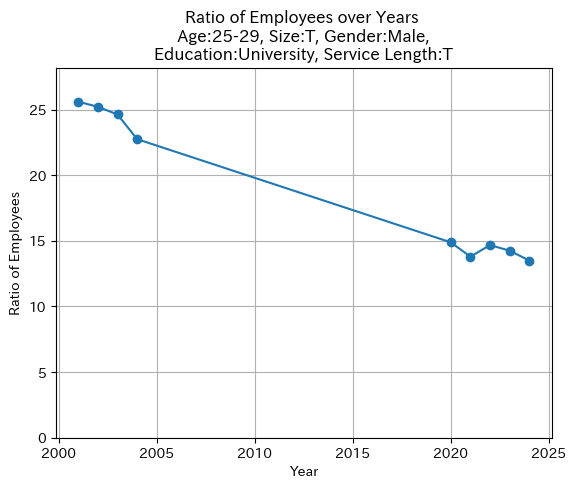

In [236]:
# dfをyearをx軸、num_of_employees_ratioをy軸としてプロット
plt.plot(df["year"], df["num_of_employees_ratio"], marker='o')
plt.xlabel("Year")
plt.ylabel("Ratio of Employees")
plt.title(f"Ratio of Employees over Years \n Age:{age_group}, Size:{company_size}, Gender:{gender}, \nEducation:{education_level}, Service Length:{service_length}")
plt.ylim(0, max(df["num_of_employees_ratio"]) * 1.1)
plt.grid(True)
plt.show()

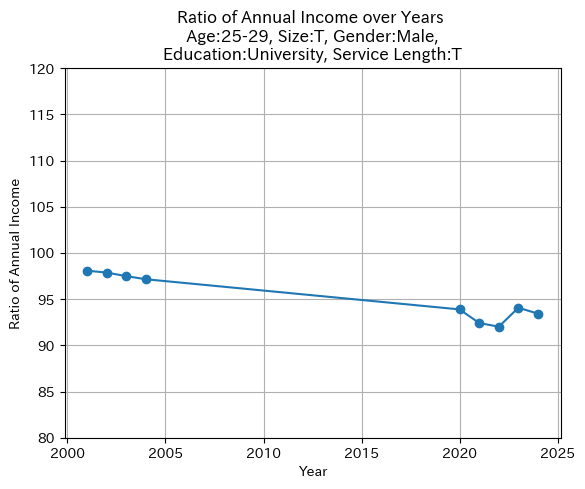

In [237]:
# dfをyearをx軸、total_annual_income_ratioをy軸としてプロット
plt.plot(df["year"], df["total_annual_income_ratio"], marker='o')
plt.xlabel("Year")
plt.ylabel("Ratio of Annual Income")
plt.title(f"Ratio of Annual Income over Years \n Age:{age_group}, Size:{company_size}, Gender:{gender}, \nEducation:{education_level}, Service Length:{service_length}")
plt.ylim(80, 120)
plt.grid(True)
plt.show()

Interpolated Data (2003-2006):
   year  num_of_employees_ratio  total_annual_income_ratio
2  2003               24.629000                  97.487000
3  2004               22.750000                  97.150000
4  2005               22.258563                  96.946125
5  2006               21.767125                  96.742250


C:\Users\chika\AppData\Local\Temp\ipykernel_19444\2298702786.py:15: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_interpolated = df_reindexed.interpolate(method='linear')


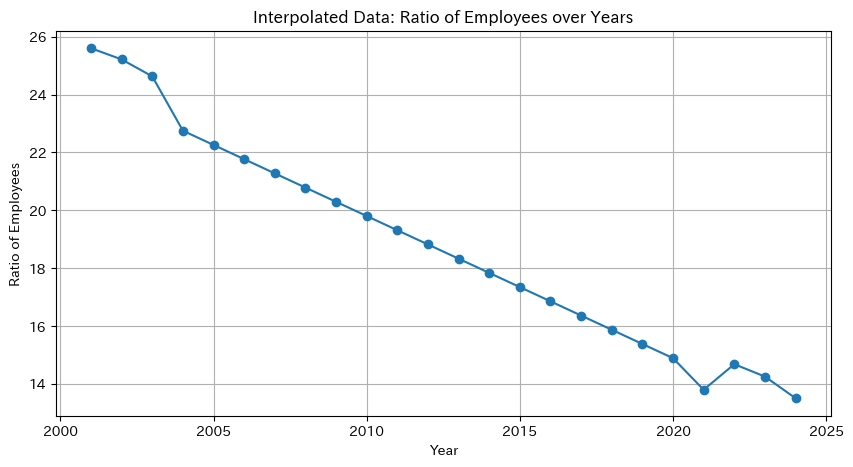

In [234]:
# 欠損している年（2004-2019）を線形補間で埋める

# 年をインデックスにして、全期間（最小年から最大年まで）でリインデックス
min_year = df["year"].min()
max_year = df["year"].max()
full_years = np.arange(min_year, max_year + 1)

# yearをインデックスに設定
df_indexed = df.set_index("year")

# 足りない年を追加（値はNaNになる）
df_reindexed = df_indexed.reindex(full_years)

# 線形補間を実行
df_interpolated = df_reindexed.interpolate(method='linear')

# カテゴリカルな列（company_sizeなど）は、前後の値で埋める
df_interpolated = df_interpolated.ffill().bfill()

# インデックスを列に戻してdfを更新
df = df_interpolated.reset_index().rename(columns={"index": "year"})

# 補間されたデータの確認（一部）
print("Interpolated Data (2003-2006):")
print(df[(df["year"] >= 2003) & (df["year"] <= 2006)][["year", "num_of_employees_ratio", "total_annual_income_ratio"]])

# 補間後のデータをプロットして確認
plt.figure(figsize=(10, 5))
plt.plot(df["year"], df["num_of_employees_ratio"], marker='o', label='Interpolated Data')
plt.xlabel("Year")
plt.ylabel("Ratio of Employees")
plt.title("Interpolated Data: Ratio of Employees over Years")
plt.grid(True)
plt.show()

### 線形回帰

In [238]:
df_to_predict = df.copy()

In [239]:
df_to_predict["year_normalized"] = df_to_predict["year"] - df_to_predict["year"].min()
df_to_predict.head()

,year,company_size,gender,education_level,age_group,service_length,monthly_wage,annual_bonus,num_of_employees,total_annual_income,monthly_wage_total,annual_bonus_total,total_annual_income_total,num_of_employees_total,monthly_wage_ratio,annual_bonus_ratio,total_annual_income_ratio,num_of_employees_ratio,year_normalized
2515,2001,T,Male,University,25-29,T,249900.0,891700.0,216760.0,3890500.0,257500.0,876800.0,3966800.0,846650.0,97.049,101.699,98.077,25.602,0
5736,2002,T,Male,University,25-29,T,248000.0,875700.0,205630.0,3851700.0,255300.0,871800.0,3935400.0,815500.0,97.141,100.447,97.873,25.215,1
8951,2003,T,Male,University,25-29,T,249000.0,806100.0,194590.0,3794100.0,256800.0,810300.0,3891900.0,790080.0,96.963,99.482,97.487,24.629,2
12179,2004,T,Male,University,25-29,T,245300.0,785300.0,189530.0,3728900.0,255200.0,775900.0,3838300.0,833100.0,96.121,101.211,97.150,22.750,3
63877,2020,T,Male,University,25-29,T,244700.0,850000.0,115380.0,3786400.0,266200.0,838500.0,4032900.0,775030.0,91.923,101.371,93.888,14.887,19


In [240]:
X = pd.DataFrame({
    'total_annual_income_ratio': np.log(df_to_predict["total_annual_income_ratio"]),
    "year": df_to_predict["year_normalized"]
    }) # 中年層の賃金（対数）
y = np.log(df_to_predict[["num_of_employees_ratio"]])          # 労働者数（対数）

In [241]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X,y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [246]:
intercept = model.intercept_[0]
coef_wage = model.coef_[0][0]
coef_year = model.coef_[0][1]

print(f"賃金の係数 : {coef_wage:.4f}")
print(f"年の係数: {coef_year:.4f}")
print(f"切片: {intercept:.4f}")
print("-" * 20)
print(f"モデル式: log(y) = {intercept:.4f} + {coef_wage:.4f} * log(x1) + {coef_year:.4f} * x2")
print("  y: 従業員比率")
print("  x1: 賃金比率")
print(f"  x2: 年 - {min_year}")

賃金の係数 : 1.3326
年の係数: -0.0247
切片: -2.8687
--------------------
モデル式: log(y) = -2.8687 + 1.3326 * log(x1) + -0.0247 * x2
  y: 従業員比率
  x1: 賃金比率
  x2: 年 - 2001


In [243]:
# 2035年までの予測
# total_annual_income_ratioが、future_years年間で +percentage % になると仮定
percentage = 10  # future_years全体での増加率
future_years = 5
curr_wage = df["total_annual_income_ratio"].iloc[-1]
last_year = df["year"].iloc[-1]
min_year = df["year"].min()

# 目標賃金比率を計算し、そこに向けて線形に増加させると仮定
target_wage = curr_wage * (1 + percentage / 100)
future_wage_up = np.linspace(curr_wage, target_wage, future_years + 1)[1:]

future_years_list = [last_year + i for i in range(1, future_years + 1)]

# 学習時と同様に、yearから最小年を引いて正規化する
future_years_normalized = [y - min_year for y in future_years_list]

X_future = pd.DataFrame({
    'total_annual_income_ratio': np.log(future_wage_up),
    'year': future_years_normalized
})

y_future_pred = model.predict(X_future)
y_future_pred_exp = np.exp(y_future_pred)

for year, income_ratio, num_employees_ratio in zip(future_years_list, future_wage_up, y_future_pred_exp):
    print(f"Year: {year}, Predicted Total Annual Income Ratio: {income_ratio:.2f}, Predicted Number of Employees Ratio: {num_employees_ratio[0]:.2f}")

Year: 2025, Predicted Total Annual Income Ratio: 95.30, Predicted Number of Employees Ratio: 13.61
Year: 2026, Predicted Total Annual Income Ratio: 97.17, Predicted Number of Employees Ratio: 13.62
Year: 2027, Predicted Total Annual Income Ratio: 99.03, Predicted Number of Employees Ratio: 13.63
Year: 2028, Predicted Total Annual Income Ratio: 100.90, Predicted Number of Employees Ratio: 13.63
Year: 2029, Predicted Total Annual Income Ratio: 102.77, Predicted Number of Employees Ratio: 13.63


In [244]:
# 直近のtotal_annual_income_totalを取得（将来も一定と仮定）
current_total_annual_income_total = df["total_annual_income_total"].iloc[-1]

# 将来の賃金実数を計算 (比率 * 全体)
future_total_annual_income = (future_wage_up/100) * current_total_annual_income_total

# 結果の表示
print(f"Base Total Annual Income (Total, Last Year): {current_total_annual_income_total:,.0f}")
print(f"Base Total Monthly Income (Total, Last Year): {current_total_annual_income_total/12:,.0f}")
for year, wage in zip(future_years_list, future_total_annual_income):
    print(f"Year: {year}, Predicted Total Annual Income (Specific Total): {wage:,.0f}, Monthly: {wage/12:,.0f}")

Base Total Annual Income (Total, Last Year): 4,368,400
Base Total Monthly Income (Total, Last Year): 364,033
Year: 2025, Predicted Total Annual Income (Specific Total): 4,162,935, Monthly: 346,911
Year: 2026, Predicted Total Annual Income (Specific Total): 4,244,561, Monthly: 353,713
Year: 2027, Predicted Total Annual Income (Specific Total): 4,326,187, Monthly: 360,516
Year: 2028, Predicted Total Annual Income (Specific Total): 4,407,813, Monthly: 367,318
Year: 2029, Predicted Total Annual Income (Specific Total): 4,489,440, Monthly: 374,120


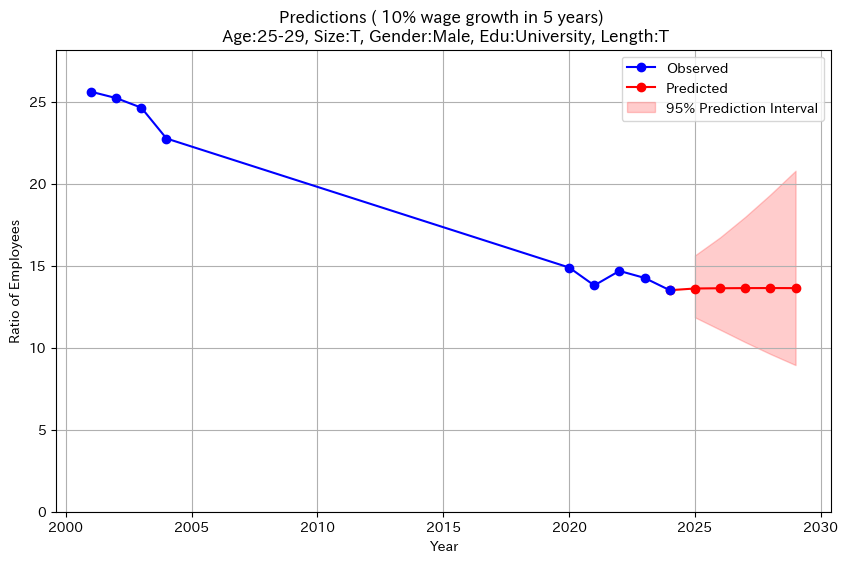

In [245]:
# 予測を結合してプロット
# 2025年以降は赤色にする
import scipy.stats as stats

# --- 95%予測区間の計算 ---
# 1. 学習データの残差と標準誤差を計算
y_train_pred = model.predict(X)
# yはDataFrameなのでflattenして1次元配列にする
residuals = y.values.flatten() - y_train_pred.flatten()
n = len(residuals)
p = X.shape[1]  # 特徴量の数
dof = n - p - 1 # 自由度
sigma = np.sqrt(np.sum(residuals**2) / dof) # 残差の標準誤差

# 2. デザイン行列の作成 (切片項を追加)
X_design = np.hstack([np.ones((n, 1)), X.values])
XtX_inv = np.linalg.inv(np.dot(X_design.T, X_design))

# 3. 将来データの予測区間を計算
t_value = stats.t.ppf(0.975, dof) # 95%信頼区間のt値 (両側)
prediction_intervals = []

for i in range(len(X_future)):
    x0 = np.hstack([1, X_future.iloc[i].values]) # 切片項を追加
    # 予測値の分散 = sigma^2 * (1 + x0^T * (X^T X)^-1 * x0)
    var_pred = sigma**2 * (1 + np.dot(np.dot(x0, XtX_inv), x0.T))
    se_pred = np.sqrt(var_pred)
    prediction_intervals.append(t_value * se_pred)

prediction_intervals = np.array(prediction_intervals)

# 4. 対数スケールから元のスケールに戻す
# y_future_pred は前のセルで計算されている (対数スケール)
y_pred_log = model.predict(X_future).flatten()
lower_bound = np.exp(y_pred_log - prediction_intervals)
upper_bound = np.exp(y_pred_log + prediction_intervals)
# ---------------------------

all_years = df["year"].tolist() + future_years_list
future_y = y_future_pred_exp
all_num_employees_ratio = df["num_of_employees_ratio"].tolist() + future_y.flatten().tolist()

plt.figure(figsize=(10, 6))
# zorderを指定して、Observedを手前に表示 (zorderが大きいほど手前)
plt.plot(all_years[:len(df)], all_num_employees_ratio[:len(df)], marker='o', color='blue', label='Observed', zorder=10)
# 接続するために、実データの最後の点を含めてプロットする
plt.plot(all_years[len(df)-1:], all_num_employees_ratio[len(df)-1:], marker='o', color='red', label='Predicted', zorder=5)

# 信頼区間（予測区間）のプロット
plt.fill_between(future_years_list, lower_bound, upper_bound, color='red', alpha=0.2, label='95% Prediction Interval', zorder=1)

plt.xlabel("Year")
plt.ylabel("Ratio of Employees")
plt.title(f"Predictions ( {percentage}% wage growth in {future_years} years) \n Age:{age_group}, Size:{company_size}, Gender:{gender}, Edu:{education_level}, Length:{service_length}")
plt.ylim(0, max(max(all_num_employees_ratio), max(upper_bound)) * 1.1)
plt.grid(True)
plt.legend()
plt.show()

### ARIMAXモデル

In [93]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [94]:
# SARIMAXモデルのために、インデックスを日付型（年次）に設定
# statsmodelsで時系列予測を行うには、適切な日付インデックスと頻度(freq)の設定が必要です
df_sarima = df.copy()
df_sarima.index = pd.to_datetime(df_sarima['year'], format='%Y')
df_sarima.index.freq = 'YS' # 年初(Year Start)として頻度を設定

X = df_sarima[["total_annual_income_ratio"]] # 外生変数: 中年層の賃金
y = df_sarima["num_of_employees_ratio"]      # 内生変数: 労働者数

In [130]:
# モデルの定義と学習
# enforce_stationarity=False, enforce_invertibility=False を設定して、
# パラメータ推定の制約を緩和し、警告を回避します（データ数が少ない場合などに有効です）
model = SARIMAX(endog=y, exog=X, order=(1, 1, 1), trend='c', 
                enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()

# 結果の表示
print(results.summary())

                                 SARIMAX Results                                  
Dep. Variable:     num_of_employees_ratio   No. Observations:                   24
Model:                   SARIMAX(1, 1, 1)   Log Likelihood                   8.939
Date:                    Mon, 01 Dec 2025   AIC                             -5.878
Time:                            19:34:50   BIC                              0.389
Sample:                                 0   HQIC                            -4.518
                                     - 24                                         
Covariance Type:                      opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
intercept                    -0.4962      0.093     -5.350      0.000      -0.678      -0.314
total_annual_income_ratio     2.8727      1.693      1

c:\vscode\k417\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\vscode\k417\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Forecasted Number of Employees Ratio:
2025-01-01    45.604743
2026-01-01    46.016843
2027-01-01    45.972114
2028-01-01    45.967835
2029-01-01    45.963837
2030-01-01    45.963384
2031-01-01    45.966229
2032-01-01    45.972412
2033-01-01    45.981947
2034-01-01    45.994850
Freq: YS-JAN, Name: predicted_mean, dtype: float64


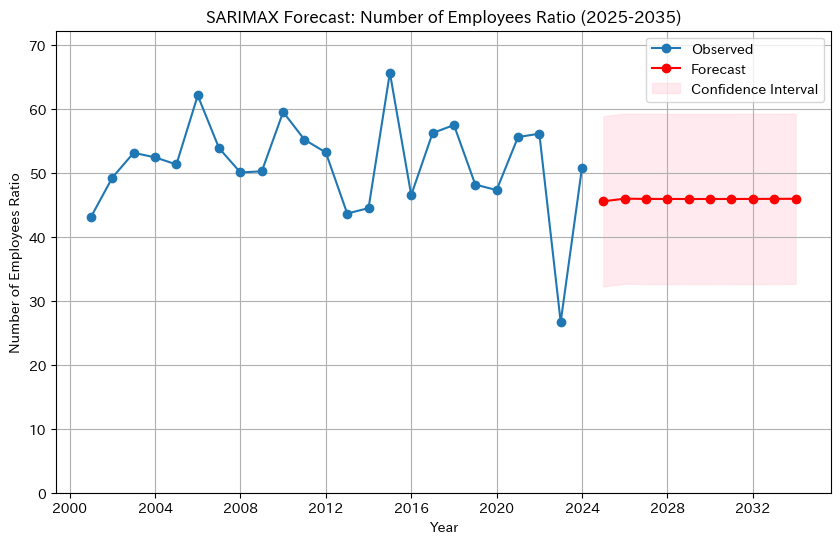

In [98]:
# 2035年までの予測 (SARIMAX)
future_years_sarima = list(range(2025, 2035))
future_dates = pd.to_datetime([f'{year}-01-01' for year in future_years_sarima])

# 外生変数 (X) の将来値を作成 (前年比 1.01倍)
last_income_ratio_sarima = df_sarima["total_annual_income_ratio"].iloc[-1]
future_income_ratios = []
for _ in future_years_sarima:
    last_income_ratio_sarima *= multipy
    future_income_ratios.append(last_income_ratio_sarima)

future_exog = pd.DataFrame({'total_annual_income_ratio': future_income_ratios}, index=future_dates)
future_exog.index.freq = 'YS'

# 予測の実行
forecast = results.get_forecast(steps=len(future_years_sarima), exog=future_exog)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# 結果の表示
print("Forecasted Number of Employees Ratio:")
print(forecast_mean)

# プロット
plt.figure(figsize=(10, 6))
plt.plot(df_sarima.index, df_sarima["num_of_employees_ratio"], label='Observed', marker='o')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', marker='o', color='red')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
plt.xlabel("Year")
plt.ylabel("Number of Employees Ratio")
plt.ylim(0, max(df_sarima["num_of_employees_ratio"].max(), forecast_mean.max()) * 1.1)
plt.title("SARIMAX Forecast: Number of Employees Ratio (2025-2035)")
plt.legend()
plt.grid(True)
plt.show()